In [18]:
# Standar library
import os
import random

# Third-party library: Numpy, Matplotlib, OpenCV
import numpy as np
import cv2
import matplotlib.pyplot as plt

# scikit-image: io, util, transform, metrics
from skimage.io import imread
from skimage.util import random_noise, crop
from skimage.transform import resize, rotate
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# scikit-learn: metrics, model selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# TensorFlow Keras: models, layers, optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, Dropout, BatchNormalization, Concatenate
)
from tensorflow.keras.optimizers import Adam

# **Load Data**

In [2]:
os.listdir('/kaggle/input/tomatofruits/Three Classes')

['Unripe', 'Reject', 'Ripe']

In [3]:
dataset_path = '/kaggle/input/tomatofruits/Three Classes'

In [4]:
def load_raw_images(dataset_path):
    images = []
    labels = []
    all_classes = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

    for label in all_classes:
        class_path = os.path.join(dataset_path, label)
        image_files = os.listdir(class_path)

        for file in image_files:
            img_path = os.path.join(class_path, file)
            try:
                img = imread(img_path)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Gagal membaca data citra {img_path}: {e}")

    return images, labels, all_classes

raw_images, labels, classes = load_raw_images(dataset_path)
print(f"Total citra mentah: {len(raw_images)}, Jumlah kelas: {len(classes)}")

Total citra mentah: 2400, Jumlah kelas: 3


# **Preprocessing Data (Autoencoder)**

In [5]:
def preprocess_images(images, img_size=(128, 128)):
    processed_images = []

    for img in images:
        try:
            # Jika gambar bukan float, ubah ke float32 dan normalisasi ke [0,1]
            if img.dtype != np.float32 and img.dtype != np.float64:
                img = img.astype(np.float32) / 255.0

            # Resize ke ukuran target, preserve_range=True agar nilai tetap di [0,1]
            img_resized = resize(img, img_size, anti_aliasing=True, preserve_range=True)

            # Jika grayscale, ubah ke RGB
            if img_resized.ndim == 2:
                img_resized = np.stack([img_resized] * 3, axis=-1)

            # Jika RGBA, buang channel alpha
            if img_resized.shape[-1] == 4:
                img_resized = img_resized[..., :3]

            processed_images.append(img_resized.astype(np.float32))

        except Exception as e:
            print(f"Gagal memproses citra: {e}")

    return np.array(processed_images, dtype=np.float32)

processed_images = preprocess_images(raw_images, img_size=(128, 128))
print(f"Total citra setelah preprocessing: {processed_images.shape}")

Total citra setelah preprocessing: (2400, 128, 128, 3)


# **Generate Noise Data (Autoencoder)**

In [6]:
def generate_noisy_versions(image, noise_factor=0.3, mask_size=32):
    noisy_versions = {}

    # 1. Gaussian Noise
    gaussian = image + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=image.shape)
    gaussian = np.clip(gaussian, 0., 1.)
    noisy_versions["gaussian"] = gaussian

    # 2. Salt & Pepper Noise
    s_and_p = random_noise(image, mode='s&p', amount=0.05)
    noisy_versions["salt_pepper"] = s_and_p

    # 3. Speckle Noise (multiplicative noise)
    speckle = random_noise(image, mode='speckle')
    noisy_versions["speckle"] = speckle

    # 4. Poisson Noise
    poisson = random_noise(image, mode='poisson')
    noisy_versions["poisson"] = poisson

    # 5. Gaussian Blur
    image_255 = (image * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(image_255, (5, 5), sigmaX=1)
    blurred = blurred.astype(np.float32) / 255.
    noisy_versions["blur"] = blurred

    # 6. Random Masking (block dropout)
    masked = image.copy()
    h, w, _ = masked.shape
    x = np.random.randint(0, w - mask_size)
    y = np.random.randint(0, h - mask_size)
    masked[y:y+mask_size, x:x+mask_size, :] = 0
    noisy_versions["masked"] = masked

    return noisy_versions

In [7]:
noisy_images = []
original_images = []

for img in processed_images:
    noisy_versions = generate_noisy_versions(img)

    # Tambahkan semua versi noise ke dataset
    for version in noisy_versions.values():
        noisy_images.append(version)
        original_images.append(img)  # target selalu gambar aslinya

noisy_images = np.array(noisy_images, dtype=np.float32)
original_images = np.array(original_images, dtype=np.float32)

print(f"Total noisy images: {noisy_images.shape}")
print(f"Total original images (targets): {original_images.shape}")

Total noisy images: (14400, 128, 128, 3)
Total original images (targets): (14400, 128, 128, 3)


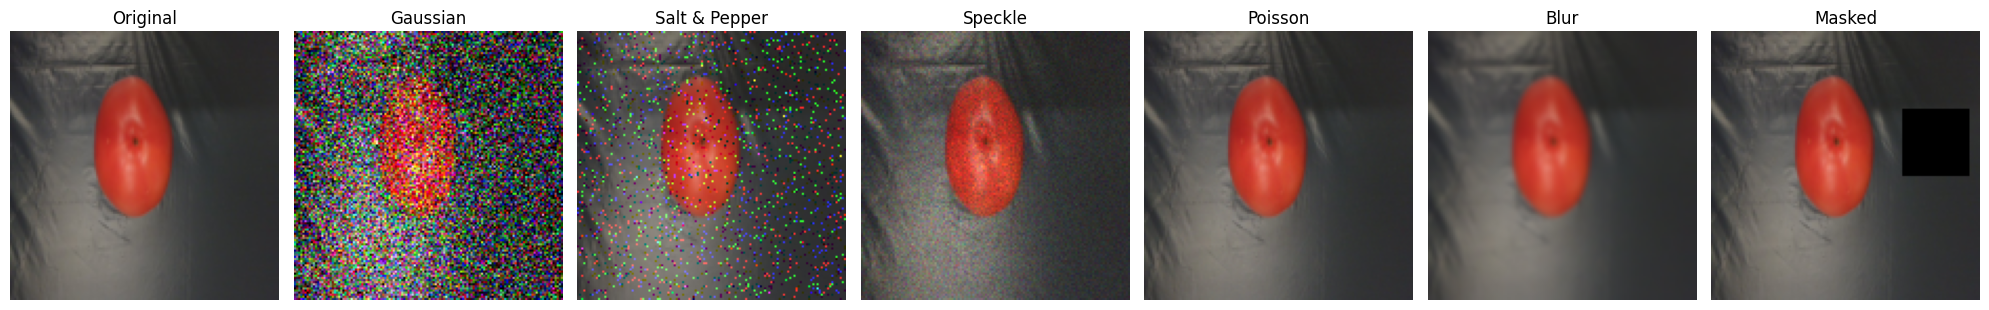

In [8]:
# Ambil indeks gambar random
random_idx = random.randint(0, len(processed_images) - 1)

# Hitung posisi di noisy_images dan original_images
start_idx = random_idx * 6  # karena 1 gambar punya 6 noisy versi

# Tampilkan gambar asli + 6 versi noise-nya
plt.figure(figsize=(20, 5))

# Gambar asli
plt.subplot(1, 7, 1)
plt.imshow(original_images[start_idx])
plt.title("Original")
plt.axis("off")

# Nama-nama noise (sesuai urutan di fungsi generate_noisy_versions)
noise_names = ["Gaussian", "Salt & Pepper", "Speckle", "Poisson", "Blur", "Masked"]

# Gambar-gambar noisy-nya
for i in range(6):
    plt.subplot(1, 7, i + 2)
    plt.imshow(noisy_images[start_idx + i])
    plt.title(noise_names[i])
    plt.axis("off")

plt.tight_layout()
plt.show()

# **Training Model (Autoencoder)**

In [9]:
def evaluate_autoencoder(model, x_data, y_true):
    # Predict hasil rekonstruksi
    y_pred = model.predict(x_data)
    
    mse_list = []
    psnr_list = []
    ssim_list = []

    for i in range(len(x_data)):
        original = y_true[i]
        reconstructed = y_pred[i]

        # MSE
        mse = np.mean((original - reconstructed) ** 2)
        mse_list.append(mse)

        # PSNR
        psnr_val = psnr(original, reconstructed, data_range=1.0)
        psnr_list.append(psnr_val)

        # SSIM
        ssim_val = ssim(original, reconstructed, channel_axis=-1, data_range=1.0)
        ssim_list.append(ssim_val)

    # Rata-rata dari semua citra
    avg_mse = np.mean(mse_list)
    avg_psnr = np.mean(psnr_list)
    avg_ssim = np.mean(ssim_list)

    # Tampilkan hasil
    print(f"Rata-rata MSE  : {avg_mse:.4f}")
    print(f"Rata-rata PSNR : {avg_psnr:.2f} dB")
    print(f"Rata-rata SSIM : {avg_ssim:.4f}")

In [10]:
def plot_training_history(history, title='Training Loss History'):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [11]:
x_train, x_test, y_train, y_test = train_test_split(
    noisy_images, original_images, test_size=0.2, random_state=42
)

In [12]:
input_shape = x_train.shape[1:]  # (128, 128, 3)
input_img = Input(shape=input_shape)

## Model 1

In [13]:
# Encoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)                # 128x128x64
x = MaxPooling2D((2, 2), padding='same')(x)                                         # 64x64x64

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)                        # 64x64x32
x = MaxPooling2D((2, 2), padding='same')(x)                                         # 32x32x32

x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)                        # 32x32x16
encoded = MaxPooling2D((2, 2), padding='same')(x)                                   # 16x16x16

# Decoder
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)                  # 16x16x16
x = UpSampling2D((2, 2))(x)                                                         # 32x32x16

x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)                        # 32x32x32
x = UpSampling2D((2, 2))(x)                                                         # 64x64x32

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)                        # 64x64x64
x = UpSampling2D((2, 2))(x)                                                         # 128x128x64

decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)   # 128x128x3

# Model
autoencoder_1 = Model(input_img, decoded)
autoencoder_1.compile(optimizer=Adam(), loss='binary_crossentropy')

autoencoder_1.summary()

I0000 00:00:1750865458.611335      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750865458.611976      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d (UpSampling2D)         │ (None, 32, 32, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 32, 32, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_1 (UpSampling2D)       │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 128, 128, 3)         │           1,731 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,067 (203.39 KB)

 Trainable params: 52,067 (203.39 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
history_ae_1 = autoencoder_1.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test, y_test)
)

Epoch 1/20


I0000 00:00:1750865474.257528     109 service.cc:148] XLA service 0x78648c09f640 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750865474.258257     109 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750865474.258278     109 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750865474.816405     109 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/360 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - loss: 0.6924

I0000 00:00:1750865479.471194     109 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


360/360 ━━━━━━━━━━━━━━━━━━━━ 26s 47ms/step - loss: 0.6071 - val_loss: 0.5785
Epoch 2/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - loss: 0.5792 - val_loss: 0.5776
Epoch 3/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 0.5789 - val_loss: 0.5773
Epoch 4/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - loss: 0.5783 - val_loss: 0.5772
Epoch 5/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.5780 - val_loss: 0.5768
Epoch 6/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.5776 - val_loss: 0.5766
Epoch 7/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.5775 - val_loss: 0.5764
Epoch 8/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.5771 - val_loss: 0.5764
Epoch 9/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.5771 - val_loss: 0.5763
Epoch 10/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.5770 - val_loss: 0.5761
Epoch 11/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 14s 38ms/step - loss: 0.5772 - val_loss: 0.5761
Epoch 12/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 

In [15]:
evaluate_autoencoder(autoencoder_1, x_test, y_test)

90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Rata-rata MSE  : 0.0007
Rata-rata PSNR : 32.31 dB
Rata-rata SSIM : 0.8618


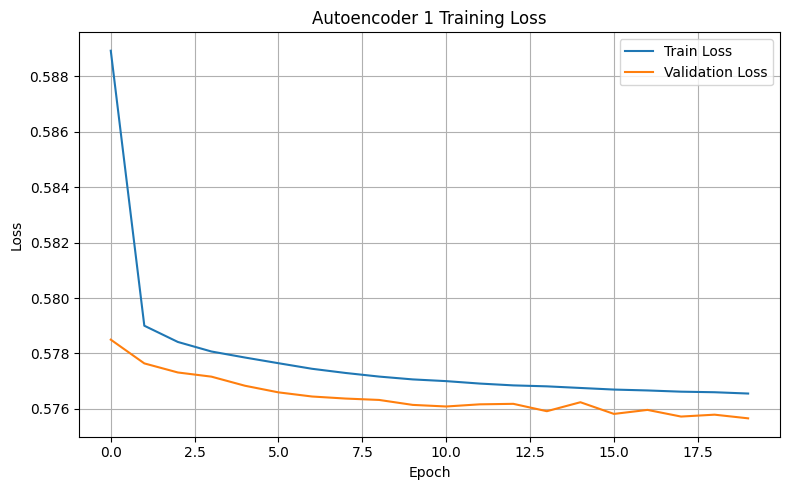

In [16]:
plot_training_history(history_ae_1, title='Autoencoder 1 Training Loss')

## Model 2

In [19]:
# Encoder
x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x1 = BatchNormalization()(x1)
p1 = MaxPooling2D((2, 2), padding='same')(x1)  # 64x64x64

x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
x2 = BatchNormalization()(x2)
p2 = MaxPooling2D((2, 2), padding='same')(x2)  # 32x32x128

x3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
x3 = BatchNormalization()(x3)
encoded = MaxPooling2D((2, 2), padding='same')(x3)  # 16x16x256

# Decoder
x = Conv2D(256, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # 32x32x256
x = Concatenate()([x, x3])  # skip connection

x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # 64x64x128
x = Concatenate()([x, x2])  # skip connection

x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)  # 128x128x64
x = Concatenate()([x, x1])  # skip connection

decoded = Conv2D(input_shape[2], (3, 3), activation='sigmoid', padding='same')(x)  # 128x128x3

# Model
autoencoder_2 = Model(input_img, decoded)
autoencoder_2.compile(optimizer=Adam(learning_rate=1e-4), loss='mean_squared_error')

autoencoder_2.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 64)   │            256 │ conv2d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 64, 64, 64)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 64, 64, 128)    │            512 │ conv2d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 32, 32, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 256)    │          1,024 │ conv2d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 16, 16, 256)    │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 16, 16, 256)    │        590,080 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 256)    │          1,024 │ conv2d_11[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ up_sampling2d_3           │ (None, 32, 32, 256)    │              0 │ batch_normalization_3… │
│ (UpSampling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 32, 32, 512)    │              0 │ up_sampling2d_3[0][0], │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 128)    │        589,952 │ concatenate[0][0]      │
├──────────────────────

 Total params: 1,705,411 (6.51 MB)

 Trainable params: 1,703,619 (6.50 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [20]:
history_ae_2 = autoencoder_2.fit(
    x_train, y_train,
    epochs=20,
    batch_size=32,
    shuffle=True,
    validation_data=(x_test, y_test)
)

Epoch 1/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 77s 148ms/step - loss: 0.0253 - val_loss: 0.0088
Epoch 2/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 46s 128ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 3/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 4/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 126ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 5/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 126ms/step - loss: 0.0012 - val_loss: 0.0031
Epoch 6/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 126ms/step - loss: 9.8694e-04 - val_loss: 0.0023
Epoch 7/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 126ms/step - loss: 9.6578e-04 - val_loss: 0.0028
Epoch 8/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - loss: 7.8615e-04 - val_loss: 7.7550e-04
Epoch 9/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 126ms/step - loss: 9.9006e-04 - val_loss: 0.0011
Epoch 10/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - loss: 7.5772e-04 - val_loss: 5.9673e-04
Epoch 11/20
360/360 ━━━━━━━━━━━━━━━━━━━━ 45s 125ms/step - loss: 6.3272e-04 - val_

In [21]:
evaluate_autoencoder(autoencoder_2, x_test, y_test)

90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step
Rata-rata MSE  : 0.0005
Rata-rata PSNR : 35.32 dB
Rata-rata SSIM : 0.9089


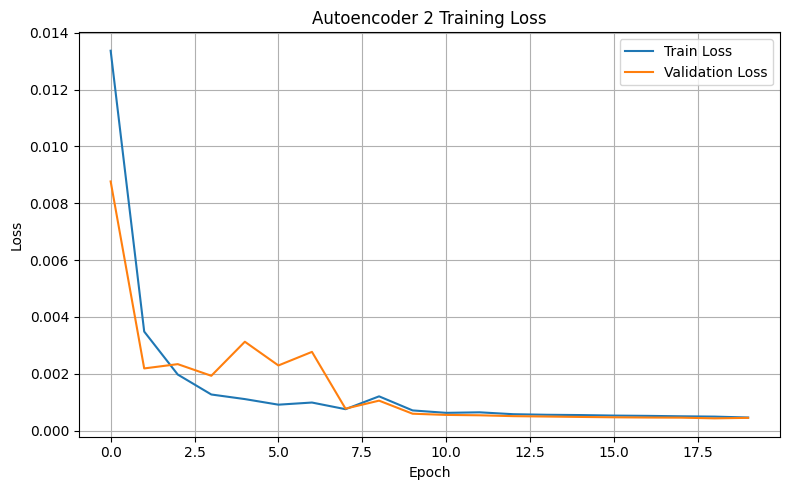

In [22]:
plot_training_history(history_ae_2, title='Autoencoder 2 Training Loss')

# **Testing Model (Autoencoder)**

90/90 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


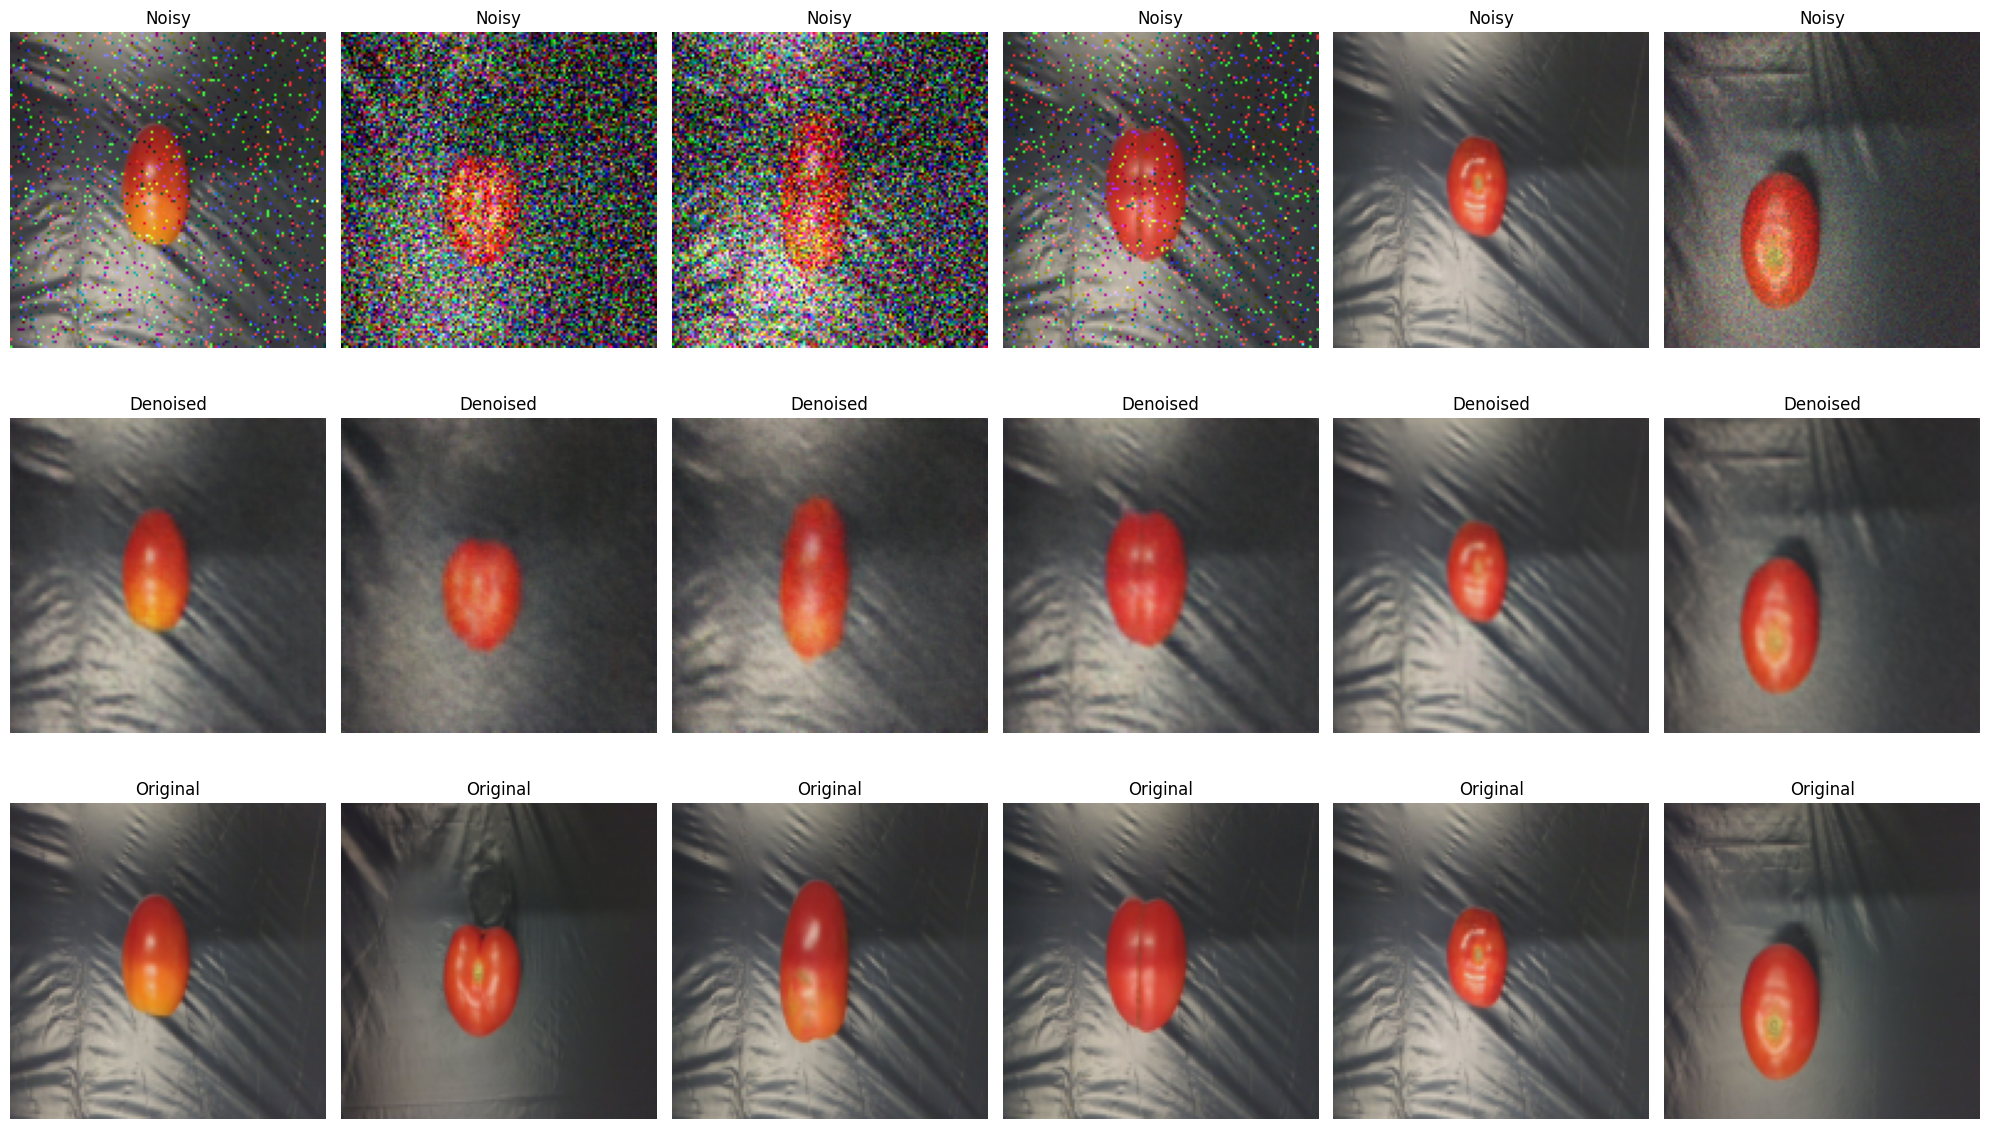

In [27]:
decoded_imgs = autoencoder_2.predict(x_test)

n = 6
plt.figure(figsize=(20, 12))
for i in range(n):
    # Input Noisy
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Noisy")
    plt.axis("off")

    # Output Denoised
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("Denoised")
    plt.axis("off")

    # Ground Truth
    ax = plt.subplot(3, n, i + 1 + 2 * n)
    plt.imshow(y_test[i])
    plt.title("Original")
    plt.axis("off")
plt.tight_layout()
plt.show()

In [25]:
autoencoder_2.save('autoencoder_denoise.h5')